# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d200/c5a5dc784c0e2b77accc1a6f594b2ff9418908154063a8391ffd53b8.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Toronto, Ontario, Canada**, and the stations the data comes from are shown on the map below.

In [22]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(200,'c5a5dc784c0e2b77accc1a6f594b2ff9418908154063a8391ffd53b8')

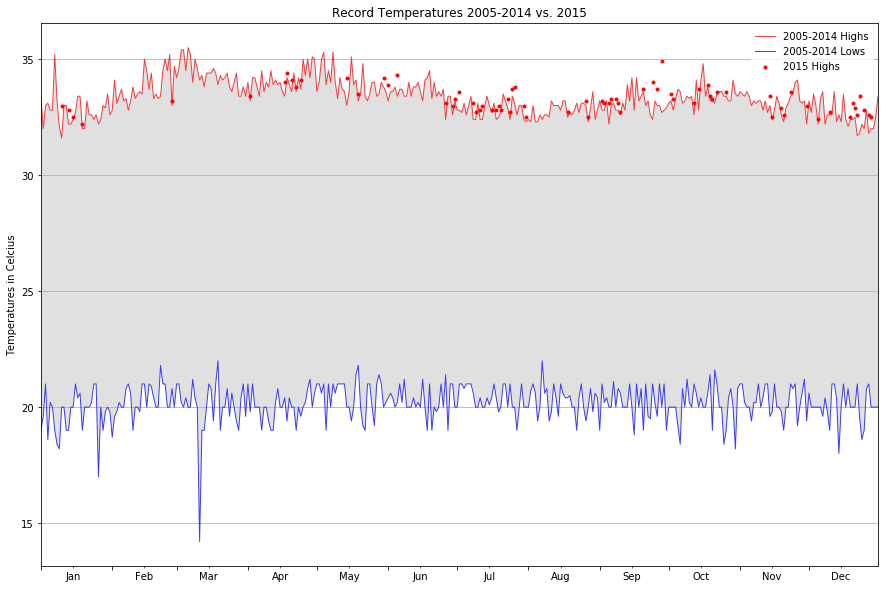

In [29]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker

# Read in and inspect the file.
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d100/4e86d2106d0566c6ad9843d882e72791333b08be3d647dcae4f4b110.csv')

df.loc[:,'Data_Value'] *= 0.1 # Convert from tenths of degrees to Degrees.

# Change to Pandas datetime format.
df['Date'] = pd.to_datetime(df['Date']) 

# Add Month and Day columns.
df['Day'] = pd.DatetimeIndex(df['Date']).day 
df['Month'] = pd.DatetimeIndex(df['Date']).month 
df = df.set_index(['Month','Day']) 
df.sort_index(inplace = True)

# Remove any February 29 leap year rows so that each year has 365 days.
leap_df = df.loc[2,29] 
df = df[~df.index.isin(leap_df.index)] 

# Create a year column
df['Year'] = pd.DatetimeIndex(df['Date']).year

# Split into a 2015 and a 2004-2014 dataframes
df_2015 = df[df['Year'] == 2015] 
df = df[df['Year'] != 2015] 

# Create a Pandas array of days of the year.
yearRange = df_2015['Date'].unique()

# Create Minimum and Maximum dataframes for both 2004-2014 and 2015.
min_df = df[df['Element'] == 'TMIN'] 
max_df = df[df['Element'] == 'TMAX'] 
max_df_2015 = df_2015[df_2015['Element'] == 'TMAX'] 
min_df_2015 = df_2015[df_2015['Element'] == 'TMIN']

min_df.head()

# Clear any previously existing plot.
plt.clf()

# Create dataframes for plotting results.
min_plot_df = min_df.groupby(level = ['Month', 'Day'])['Data_Value'].min()
min_plot_df_2015 = min_df_2015.groupby(level = ['Month', 'Day']).min()[['Data_Value', 'Date']]
max_plot_df = max_df.groupby(level = ['Month', 'Day'])['Data_Value'].max()
max_plot_df_2015 = max_df_2015.groupby(level = ['Month', 'Day']).max()[['Data_Value', 'Date']]

# Creating figure and an axis.
fig, axis = plt.subplots( nrows = 1, ncols = 1, figsize = (15, 10) ) 

# Add a title.
axis.set_title('Record Temperatures 2005-2014 vs. 2015') 
axis.yaxis.grid() 

# Plot lines
plt.plot(yearRange, max_plot_df.values, '#FF0000', linewidth = 1, alpha=0.75, label = '2005-2014 Highs')
plt.plot(yearRange, min_plot_df.values, '#0000FF', linewidth = 1, alpha=0.75, label = '2005-2014 Lows') 

# Add fill between lines.
plt.fill_between(yearRange, min_plot_df, max_plot_df, facecolor='#E0E0E0')

# Overlaid scatter plot indicates days in 2015 that broke a record high.
my_label_max = "2015 Highs"
for idx, rows in max_plot_df_2015.iterrows():
    if rows['Data_Value'] > max_plot_df.loc[idx]:
        plt.scatter(rows['Date'], rows['Data_Value'], c = '#FF0000', marker = '.', label = my_label_max)
        my_label_max = "_nolegend_" # Avoid duplicate labels

# Overlaid scatter plot indicates days in 2015 that broke a record low.     
my_label_min = "2015 Lows"
for idx, rows in min_plot_df_2015.iterrows():
    if rows['Data_Value'] < min_plot_df.loc[idx]:
        plt.scatter(rows['Date'], rows['Data_Value'], c = '#0000FF', marker = '.', label = my_label_min)
        my_label_min = "_nolegend_"
        
# Add a Legend to bottom-right part of graph.
plt.legend(loc = 1).get_frame().set_edgecolor('white') 

# Label y-axis.
axis.set_ylabel('Temperatures in Celcius')

# Label x-axis.
x_min = yearRange[0]
x_max = yearRange[-1]
axis.set_xlim(x_min, x_max)

# Label x-axis months with abbrevitation: Jan, Feb, ...
axis.xaxis.set_major_formatter(ticker.NullFormatter())
axis.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# Move x-axis indicator to the middle of the month.
axis.xaxis.set_major_locator(dates.MonthLocator())
axis.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

plt.show()